# IBB Assignment 3 - Ear recognition
Faculty of Computer Science, Univeristy of Ljubljana

David Valič - dv6510@student.uni-lj.si


# Instructions for running this notebook:



**Section 0: Google Drive Setup**

In this section load google drive and move to the directory where you have the following files:

(in this case, you need to run section 1.3 and 3.2)
*   `awe_train.csv`
*   `awe_test.csv`
*   `awe` folder with all the cropped ear images

OR

(in this case, you need to run 1.5 and 3.4)
*   `train_dataset.pckl`
*   `test_dataset.pckl`


Optionally you can also have a model which you wish to evaluate on test dataset.



**Section 1: CNN Setup**

In this section run:

*   **1.1** AND 
*   **1.2** AND
*   Either **1.3** if you don't have `train_dataset.pckl` in your dicrectory OR **1.5** if you have `train_dataset.pckl` in your directory AND
*  **1.6**



**Section 2: CNN Training**

In this section run:

*   Either : **2.1.a** for *identity* OR **2.1.b** for *ethnicity* OR **2.1.c** for gender classification model training AND
*   **2.2** AND
*   **2.3**

<br>
<br>
<br>

**Sections 3 & 4: Evaluation**
*   If you wish to evaluate models from all epochs from a single training go to section **3**. 
*   If you wish to evaluate a single model go to section **4**.

**Section 3: CNN Evaluation**

In this section run:

*   Either : **3.1.a** for *identity* OR **3.1.b** for *ethnicity* OR **3.1.c** for gender model evaluation AND
*   Either **3.2** if you don't have `test_dataset.pckl` in your dicrectory OR **3.4** if you have `test_dataset.pckl` in your directory AND
*   **3.6**

**Section 4: Signle CNN model Evaluation**

In this section run:
*   Either **4.1** if you don't have `test_dataset.pckl` in your dicrectory OR **4.2** if you have `test_dataset.pckl` in your directory AND
*   Either : **4.3.a** for *identity* OR **4.3.b** for *ethnicity* OR **4.3.c** for gender model evaluation AND
*   **4.4** AND
*   **4.5**






# 0. Google Drive Setup

**0.1** Mount google drive to the project

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


**0.2** Move to the directory of the 3. assignemnt where `awe-train.csv`, `awe-test.csv` and whole `awe` images directory are

In [ ]:
%cd /content/drive/MyDrive/mg/3. semester/SB/Naloge/naloga3

/content/drive/MyDrive/mg/3. semester/SB/Naloge/naloga3


# 1. CNN Setup

**1.1** Create a class for common methods used to reshape data, also se the image width and heigth used throught the whole notebook

In [ ]:
import numpy

IMG_WIDTH=224
IMG_HEIGHT=224

class Common:

    @staticmethod
    def reshape_transform_data(data):
        data = numpy.array(data)
        result = Common.reshape_data(data)
        return Common.to_float(result)

    @staticmethod
    def reshape_data(data):
        return data.reshape(data.shape[0], IMG_WIDTH, IMG_HEIGHT, 3)

    @staticmethod
    def reshape_from_img(image):
        return image.reshape((IMG_WIDTH, IMG_HEIGHT, 3))

    @staticmethod
    def to_float(value):
        return value.astype('float32')/255

**1.2** Initialize the training data class - the images and the labels for identities, ethnicities and genders

In [ ]:
import abc
import os
import random
from abc import abstractmethod

from keras_preprocessing.image import load_img, img_to_array
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
import json

FILE_TRAIN_CSV = "awe-train.csv"


class EarDataSet(metaclass=abc.ABCMeta):

    def __init__(self, classes_identity, classes_ethnicity, classes_gender):
        # to je steilo oseb - pri AWE je 100
        self.n_classes = classes_identity
        self.n_identity_classes = classes_identity
        self.n_ethnicity_classes = classes_ethnicity
        self.n_gender_classes = classes_gender
        # objects so podatki slik, ki so prebrani z io.imread() in potem reshapani ampak bo jih treba resizat tudi, tako da uporabi
        self.objects = []
        # labels so train data in so vektorji dolgi 100, ki imajo povsod 0, razen pri osebi ki je ta prava imajo 1
        self.labels = []
        self.labels_identity = []
        self.labels_ethnicity = []
        self.labels_gender = []
        # obj_validation so podatki slik, ki so prebrani z io.imread() in potem reshapani ampak bo jih treba resizat tudi, tako da uporabi
        self.obj_validation = []
        # labels_validation so test data in so vektorji dolgi 100, ki imajo povsod 0, razen pri osebi ki je ta prava imajo 1
        self.labels_validation = []
        # number_labels je steilo vseh slik, ki sodelujejo v treniranju CNN modela
        self.number_labels = 0

    def get_data(self):
        self.objects, self.labels_identity, self.labels_ethnicity, self.labels_gender = self.fetch_img_path()
        self.process_data()
        #self.print_dataSet()

    def process_data(self):
        self.labels_identity = np_utils.to_categorical(self.labels_identity, self.n_identity_classes)
        self.labels_ethnicity = np_utils.to_categorical(self.labels_ethnicity, self.n_ethnicity_classes)
        self.labels_gender = np_utils.to_categorical(self.labels_gender, self.n_gender_classes)
        self.objects = Common.to_float(numpy.asarray(self.objects, dtype= numpy.float32))


    def fetch_img_path(self):
        images = []
        labels_identity = []
        labels_ethnicity = []
        labels_gender = []
        for line in open(FILE_TRAIN_CSV):
            csv_row = line.split(",")
            file_name = csv_row[1]
            with open('awe/'+file_name.split('/')[0]+'/annotations.json') as f:
              data = json.load(f)
              ethnicity = int(data["ethnicity"])-1
              if ethnicity is 98:
                ethnicity = 7
              labels_ethnicity.append(ethnicity)
              gender = 1 # 1 means female, 0 means male
              if data["gender"] is "m":
                gender = 0
              elif data["gender"] is "f":
                gender = 1
              else:
                gender = 2 
              labels_gender.append(gender)
            image = load_img("awe/"+file_name, target_size=(IMG_WIDTH,IMG_HEIGHT))
            image = img_to_array(image)
            image = Common.reshape_from_img(image)
            label = int(csv_row[2])-1
            images.append(image)
            labels_identity.append(label)
            self.number_labels +=1

        return images, labels_identity, labels_ethnicity, labels_gender

    def print_dataSet(self):
        print(self.objects)
        print(self.labels)
    
    def set_identity_labels(self):
        self.labels = self.labels_identity
        self.n_classes = self.n_identity_classes

    def set_ethnicity_labels(self):
        self.labels = self.labels_ethnicity
        self.n_classes = self.n_ethnicity_classes

    def set_gender_labels(self):
        self.labels = self.labels_gender
        self.n_classes = self.n_gender_classes

**1.3 (or skip to 1.5 if train data file is already present)** load actual training data into dataSet variable

In [ ]:
n_identity_classes = 100
n_ethnicity_classes = 8
n_gender_classes = 2

dataSet = EarDataSet(n_identity_classes, n_ethnicity_classes, n_gender_classes)

dataSet.get_data()

**1.4 (optional)** Save loaded dataset into a file for easier later loading

In [ ]:
import pickle
f = open('train_dataset.pckl', 'wb')
pickle.dump(dataSet, f)
f.close()

**1.5 (optional) - (execute 1.3 and 1.4 if no file is present)** Loads saved dataset into a variable

In [ ]:
import pickle
f = open('train_dataset.pckl', 'rb')
dataSet = pickle.load(f)
f.close()

**1.6** Define the CNN model

In [ ]:
import numpy
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD
import datetime
import matplotlib.pyplot as plt

# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, mode='auto')
# early = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='auto')


class ConvolutionalModel():

    def __init__(self, dataSet=None):
        if dataSet is None:
            raise Exception("DataSet is required in this model")
        self.shape = numpy.array([IMG_WIDTH, IMG_HEIGHT, 3])
        self.model_summary= ""
        if dataSet is not None:
            self.objects = dataSet.objects
            self.labels = dataSet.labels
            self.obj_validation = dataSet.obj_validation
            self.labels_validation = dataSet.labels_validation
            self.number_labels = dataSet.number_labels
            self.n_classes = dataSet.n_classes
        self.init_model()
        self.cnn.compile(loss='categorical_crossentropy',
                         optimizer=SGD(lr=LEARNING_RATE, decay=1e-65, momentum=0.92, nesterov=True),
                         metrics=['accuracy'])

    def init_model(self, simple = False):
        self.cnn = Sequential()
        if simple:
          self.cnn.add(Convolution2D(32, 3, padding='same', input_shape=self.shape))
          self.cnn.add(Activation('relu'))
          self.cnn.add(Convolution2D(32, 3, 3))
          self.cnn.add(Activation('relu'))
          self.cnn.add(MaxPooling2D(pool_size=(2, 2)))
          self.cnn.add(Dropout(0.25))

          self.cnn.add(Convolution2D(64, 3, padding='same'))
          self.cnn.add(Activation('relu'))
          self.cnn.add(Convolution2D(64, 3, 3))
          self.cnn.add(Activation('relu'))
          self.cnn.add(MaxPooling2D(pool_size=(2, 2)))
          self.cnn.add(Dropout(0.25))

          self.cnn.add(Flatten())
          self.cnn.add(Dense(512))
          self.cnn.add(Activation('relu'))
          self.cnn.add(Dropout(0.5))
          self.cnn.add(Dense(self.n_classes))
          self.cnn.add(Activation('softmac'))
        else:
          self.cnn.add(Convolution2D(input_shape=self.shape, filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          self.cnn.add(Convolution2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          self.cnn.add(Convolution2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          self.cnn.add(Convolution2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          self.cnn.add(Convolution2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(Convolution2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
          self.cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          self.cnn.add(Flatten())
          self.cnn.add(Dense(units=4096, activation="relu"))
          self.cnn.add(Dense(units=4096, activation="relu"))
          self.cnn.add(Dense(units=self.n_classes, activation="softmax"))
        summary = []
        self.cnn.summary(print_fn=lambda x: summary.append(x))
        summary_filename = MODEL_PATH + "model_summary.txt"
        if not os.path.exists(os.path.dirname(summary_filename)):
          try:
            os.makedirs(os.path.dirname(summary_filename))
          except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
        with open(summary_filename,'a') as fh:
          #self.cnn.summary(print_fn=lambda x: fh.write(x + '\n'))
          fh.write('\n'.join(summary))
        print('\n'.join(summary))

    def train(self, n_epochs=100, batch=32, val_split=0., stps_p_epoch = None, validation_stps = None):
        checkpoint = ModelCheckpoint(MODEL_PATH+"models/{epoch:04d}-vgg16_1.h5", monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        filename = MODEL_PATH+"training_spec.txt"
        if not os.path.exists(os.path.dirname(filename)):
          try:
            os.makedirs(os.path.dirname(filename))
          except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
        with open(filename, 'a') as f:
              f.write("Epochs {} \nBatch_size {} \nValidation_split {} \nLearning_rate {} \nSteps_per_epoch {} \nValidation_steps {}".format(n_epochs, batch, val_split, LEARNING_RATE, stps_p_epoch, validation_stps))

        hist = self.cnn.fit(x=self.objects,
                      y=self.labels,
                      #validation_data=(self.obj_validation, self.labels_validation),
                      batch_size=batch,
                      epochs=n_epochs,
                      validation_split=val_split,
                      validation_steps=validation_stps,
                      steps_per_epoch=stps_p_epoch,
                      shuffle=True, 
                      callbacks=[checkpoint])
        
        model_training = ""
        for i in range(0, len(hist.history['accuracy'])):
          model_training += "Epoch: {} ;Loss: {} ;Accuracy: {}\n".format(
              i, hist.history['loss'][i], hist.history['accuracy'][i]
          )
        model_results_filename = MODEL_PATH+"model_training_result.txt"
        with open(model_results_filename, 'w') as f:
              f.write(model_training)
        
        plt.plot(range(1,len(hist.history['accuracy'])+1), hist.history['accuracy'])
        #plt.plot(range(1,len(hist.history['val_accuracy'])+1), hist.history['val_accuracy'])
        plt.title('Model accuracy over epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        #plt.legend(['Accuracy', 'Validation accuracy'])
        plt.savefig(fname = MODEL_PATH + 'model_accuracy.png', dpi = 300)

        plt.clf()

        plt.plot(range(1,len(hist.history['loss'])+1), hist.history['loss'])
        #plt.plot(range(1,len(hist.history['val_loss'])+1), hist.history['val_loss'])
        plt.title('Model loss over epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        #plt.legend(['Loss', 'Validation loss'])
        plt.savefig(fname = MODEL_PATH + 'model_loss.png', dpi = 300)
      
    def get_model(self):
        return self.cnn

    def predict(self, image):
        image = Common.to_float(image)
        result = self.cnn.predict(image)
        print(result)

Initialize the convolutional model and set the path for saving the model and all its data

# 2. CNN Training

Run only one 
- **2.1.a** for identity classification model training
- **2.1.b** for ethnicity classification model training
- **2.1.c** for gender classification model training

**2.1.a** Set dataset for identity classification model training

In [ ]:
dataSet.set_identity_labels()

**2.1.b** Set dataset for ethnicity classification model training

In [ ]:
dataSet.set_ethnicity_labels()

**2.1.c** Set dataset for gender classification model training

In [ ]:
dataSet.set_gender_labels()

**2.2** Set the path for saving the model data and results and setup learning rate, initialize the CNN model with the dataset and flag "Simple".

*   Simple = True -> A very simple CNN architecture is used
*   Simple = False -> VGG CNN architecture is used



In [ ]:
MODEL_PATH= "model-18-identity/"

In [ ]:
LEARNING_RATE = 0.01 

cnn = ConvolutionalModel(dataSet)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

**2.3** Start training the CNN wiht the defined parameters

Epoch 1/130
24/24 [==============================] - 23s 500ms/step - loss: 4.6060 - accuracy: 0.0025

Epoch 00001: saving model to model-19-identity/models/0001-vgg16_1.h5
Epoch 2/130
24/24 [==============================] - 10s 430ms/step - loss: 4.6053 - accuracy: 0.0184

Epoch 00002: saving model to model-19-identity/models/0002-vgg16_1.h5
Epoch 3/130
24/24 [==============================] - 10s 427ms/step - loss: 4.6052 - accuracy: 0.0131

Epoch 00003: saving model to model-19-identity/models/0003-vgg16_1.h5
Epoch 4/130
24/24 [==============================] - 10s 423ms/step - loss: 4.6044 - accuracy: 0.0058

Epoch 00004: saving model to model-19-identity/models/0004-vgg16_1.h5
Epoch 5/130
24/24 [==============================] - 10s 432ms/step - loss: 4.6052 - accuracy: 0.0062

Epoch 00005: saving model to model-19-identity/models/0005-vgg16_1.h5
Epoch 6/130
24/24 [==============================] - 10s 423ms/step - loss: 4.6030 - accuracy: 0.0108

Epoch 00006: saving model to mod

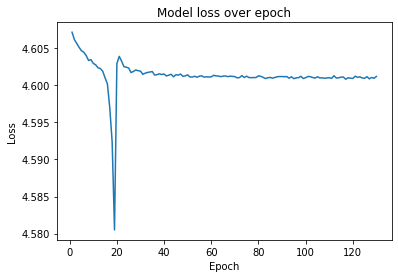

In [ ]:
cnn.train(n_epochs=130, val_split=0., batch = 32)

# 3. CNN Evaluation

This section is dedicated to evaluate all the models stored in the same folder. If you used the training above, models from all epochs for the same training will be stored in the same directory. Evaluatse number of correctly classifies objets for top1, top5 and top10 for each model.

<br>

Run only one 
- 3.1.a to evaluate the identity classification model
- 3.1.b to evaluate the ethnicity classification model
- 3.1.c to evaluate the gender classification model

**3.1.a** Set to evaluate identity classification models

In [ ]:
TYPE = "identity"

**3.1.b** Set to evaluate ethnicity classification models

In [ ]:
TYPE = "ethnicity"

**3.1.c** Set to evaluate gender classification models

In [ ]:
TYPE = "gender"

**3.2 (or skip to 3.4 if test data file is already present)** Load test data

*(requires executed code at 1.1 for the class Common)*

In [ ]:
from keras_preprocessing.image import load_img, img_to_array

FILE_TEST_CSV = "awe-test.csv"

names = []
images = []
labels = []

labels_identites = []
labels_ethnicities = []
labels_genders = []

for line in open(FILE_TEST_CSV):
    csv_row = line.split(",")
    file_name = csv_row[1]
    names.append(file_name)
    image = load_img("awe/" + file_name, target_size=(IMG_WIDTH, IMG_HEIGHT))
    image = img_to_array(image)
    image = Common.reshape_from_img(image)
    label = int(csv_row[2]) - 1
    images.append(image)
    labels_identites.append(label)
    with open('awe/'+file_name.split('/')[0]+'/annotations.json') as f:
      data = json.load(f)
      ethnicity = int(data["ethnicity"])-1
      if ethnicity is 98: # class 99 gets mapped to 8 (7 + 1)
        ethnicity = 7
      labels_ethnicities.append(ethnicity)
      gender = 1 # 1 means female, 0 means male
      if data["gender"] is "m":
        gender = 0
      elif data["gender"] is "f":
        gender = 1
      else:
        gender = 2 
      labels_genders.append(gender)

**3.3 (optional)** Save loaded data into a file to just read it later

In [ ]:
import pickle
f = open('test_dataset.pckl', 'wb')
pickle.dump([names, images, labels, labels_identites, labels_ethnicities, labels_genders], f)
f.close()

**3.4 (optional) - (execute 4.2 and 4.3 if no file is present)** Load data into a variables so no processing is needed

In [ ]:
import pickle
f = open('test_dataset.pckl', 'rb')
names, images, labels, labels_identites, labels_ethnicities, labels_genders = pickle.load(f)
f.close()

**3.5 (Optional - if not already set in training)** Define the path of the models you wish to evaluate 

In [ ]:
MODEL_PATH= "model-18-identity/"

**3.6** Evaluate top1, top5 and top10 of the selected models per epoch on test data

*(requires executed code at 1.1 for the class Common)*

In [ ]:
from tensorflow.python.keras.models import load_model
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import pickle

if TYPE is "ethnicity":
  labels = labels_ethnicities
elif TYPE is "gender":
  labels = labels_genders
else:
  labels = labels_identites

LOAD_FROM_FILE = False

if LOAD_FROM_FILE:
  f = open(MODEL_PATH + 'evaluation_data.pckl', 'rb')
  epochs, total_correct, total_top5correct, total_top10correct = pickle.load(f)
  f.close()
else:
  total_correct = []
  total_incorrect = []
  total_top5correct = []
  total_top5incorrect = []
  total_top10correct = []
  total_top10incorrect = []
  epochs = []

ranks = []

images = Common.reshape_transform_data(images)
try:
  print("here")
  for m_path in glob.glob(MODEL_PATH + "models/*.h5"):
    print(m_path)
    epoch = m_path.split("/")[2].split("-")[0]
    if int(epoch) not in epochs:
      continue
    print("Evaluating model for epoch: " + epoch)
    model = load_model(m_path)
    epochs.append(int(epoch))
    correct = 0
    incorrect = 0
    top5correct = 0
    top5incorrect = 0
    top10correct = 0
    top10incorrect = 0
    results_text = ""
    for i in range(0, len(images)):
        image = images[i]
        label = labels[i]
        prediction = model.predict(np.expand_dims(image, axis=0))
        predicted_label = np.argmax(prediction)
        if predicted_label == label:
            correct += 1
            results_text += "Image " + names[i] + " correctly classified in Top1 with label " + str(predicted_label +1) + "\n"
        else:
            incorrect += 1
            results_text += "Image " + names[i] + " incorrectly classified in Top1 with label " + str(predicted_label + 1) + " correct is " + str(label+1) + "\n"

        sorted_prediction = prediction[0].argsort()

        top5_labels = sorted_prediction[-5:][::-1]
        if label in top5_labels:
            top5correct += 1
            results_text += "Image " + names[i] + " correctly classified in Top5 with label " + str(predicted_label + 1) + "\n"
        else:
            top5incorrect += 1
            results_text += "Image " + names[i] + " incorrectly classified not in Top5 with label " + str(
                predicted_label + 1) + " correct is " + str(label + 1) + "\n"
            
        top10_labels = sorted_prediction[-10:][::-1]
        if label in top10_labels:
            top10correct += 1
            results_text += "Image " + names[i] + " correctly classified in Top10 with label " + str(predicted_label + 1) + "\n"
        else:
            top10incorrect += 1
            results_text += "Image " + names[i] + " incorrectly classified not in Top10 with label " + str(
                predicted_label + 1) + " correct is " + str(label + 1) + "\n"
        
    top1_results = "Rank 1 - Correctly classified: {} - Incorrectly classified: {}".format(correct, incorrect)
    top5_results = "Rank 5 - Correctly classified: {} - Incorrectly classified: {}".format(top5correct, top5incorrect)
    top10_results = "Rank 10 - Correctly classified: {} - Incorrectly classified: {}".format(top10correct, top10incorrect)

    filename = MODEL_PATH+"results/"+epoch+"-test_results.txt"
    if not os.path.exists(os.path.dirname(filename)):
      try:
        os.makedirs(os.path.dirname(filename))
      except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
    with open(filename, 'a') as f:
      data =  top1_results + "\n" + top5_results + "\n" +  top10_results + "\n\n" + results_text
      f.write(data)

    print(top1_results)
    print(top5_results)
    print(top10_results)
    print("\n")
    total_correct.append(correct)
    total_top5correct.append(top5correct)
    total_top10correct.append(top10correct)
except Exception as e:
  print(e)
  f = open(MODEL_PATH + 'evaluation_data.pckl', 'wb')
  pickle.dump([epochs, total_correct, total_top5correct, total_top10correct], f)
  f.close()



total_correct_percent = numpy.array(total_correct)/250
total_top5correct_percent = numpy.array(total_top5correct)/250
total_top10correct_percent = numpy.array(total_top10correct)/250

best_epochs_filename = MODEL_PATH + "best_epoch.txt"
with open(best_epochs_filename, 'a') as f:
  best_epoch_top1 = total_correct.index(max(total_correct))
  best_epoch_top5 = total_top5correct.index(max(total_top5correct))
  best_epoch_top10 = total_top10correct.index(max(total_top10correct))
  data = "Rank 1 - best epoch: {} with top1_correct: {} top5_correct: {} top10_correct: {}\n".format(epochs[best_epoch_top1], total_correct[best_epoch_top1], total_top5correct[best_epoch_top1], total_top10correct[best_epoch_top1])
  data += "Rank 5 - best epoch: {} with top1_correct: {} top5_correct: {} top10_correct: {}\n".format(epochs[best_epoch_top5], total_correct[best_epoch_top5], total_top5correct[best_epoch_top5], total_top10correct[best_epoch_top5])
  data += "Rank 10 - best epoch: {} with top1_correct: {} top5_correct: {} top10_correct: {}".format(epochs[best_epoch_top10], total_correct[best_epoch_top10], total_top5correct[best_epoch_top10], total_top10correct[best_epoch_top10])
  print("\n\nOveral best:\n" + data)
  f.write(data)

plt.plot(epochs, total_correct_percent)
plt.plot(epochs, total_top5correct_percent)
plt.plot(epochs, total_top10correct_percent)
plt.title('Correctly classified images over epoch')
plt.ylabel('Recognition rate')
plt.xlabel('Epoch')
plt.legend(['Rank 1', 'Rank 5', 'Rank 10'])
plt.savefig(fname = MODEL_PATH + 'model_validation.png', dpi = 300)

# 4. Single model evaluation

This section is dedicated to evaluate a single manually picked model and get number of correctly classifies objets for top1, top5 and top10.

**4.1 (or skip to 4.2 if test data file is already present)** Load test data

In [ ]:
from keras_preprocessing.image import load_img, img_to_array
import json

FILE_TEST_CSV = "awe-test.csv"

IMG_WIDTH=224
IMG_HEIGHT=224

names = []
images = []
labels = []

labels_identites = []
labels_ethnicities = []
labels_genders = []

for line in open(FILE_TEST_CSV):
    csv_row = line.split(",")
    file_name = csv_row[1]
    names.append(file_name)
    image = load_img("awe/" + file_name, target_size=(IMG_WIDTH, IMG_HEIGHT))
    image = img_to_array(image)
    image = image.reshape((IMG_WIDTH, IMG_HEIGHT, 3))
    label = int(csv_row[2]) - 1
    images.append(image)
    labels_identites.append(label)
    with open('awe/'+file_name.split('/')[0]+'/annotations.json') as f:
      data = json.load(f)
      ethnicity = int(data["ethnicity"])-1
      if ethnicity is 98:
        ethnicity = 7
      labels_ethnicities.append(ethnicity)
      gender = 1 # 1 means female, 0 means male
      if data["gender"] is "m":
        gender = 0
      elif data["gender"] is "f":
        gender = 1
      else:
        gender = 2 
      labels_genders.append(gender)

**4.2 (optional)** Load test data from file

In [ ]:
import pickle
f = open('test_dataset.pckl', 'rb')
names, images, labels, labels_identites, labels_ethnicities, labels_genders = pickle.load(f)
f.close()

**4.3** Define method for evaluating the selected model for selected type

In [ ]:
from tensorflow.python.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import glob
import os

def calculate_rank(model_path, type):
  n_classes = 0
  if type is "ethnicity":
    labels = labels_ethnicities
    n_classes = 7
  elif type is "gender":
    labels = labels_genders
    n_classes = 2
  else:
    labels = labels_identites
    n_classes = 100
  model = load_model(model_path)
  ranks = [0] * n_classes
  for i in range(0, len(images)):
      image = images[i]
      label = labels[i]
      prediction = model.predict(np.expand_dims(image, axis=0))
      sorted_prediction = prediction[0].argsort()
      for r in range(1, n_classes+1):
        if label in sorted_prediction[-r:][::-1]:
          ranks[r-1] += 1


  #print("Top 1 {}".format(ranks[0]))
  #print("Top 5 {}".format(ranks[4]))
  #print("Top 5 {}".format(ranks[9]))
  
  ranks_rate = np.array(ranks)/250 

  filename = "results/"+model_path+"/test_results_ranks.txt"
  if not os.path.exists(os.path.dirname(filename)):
    try:
      os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
      if exc.errno != errno.EEXIST:
          raise
  with open(filename, 'a') as f:
    ranks_array = np.char.mod('%f', ranks_rate)
    data = "\n".join(ranks_array)
    f.write(data)
  return ranks_rate


**4.4** Evaluate the selected model on test data and obtain data for CMC curve 
- 4.4.a to evaluate the identity classification model
- 4.4.b to evaluate the ethnicity classification model
- 4.4.c to evaluate the gender classification model

**4.4.a** Set to evaluate identity classification models

In [ ]:
vgg_full = calculate_rank("model-18-identity/models/0087-vgg16_1.h5", "identity")
f = open('vgg_full_identity.pckl', 'wb')
pickle.dump(vgg_full, f)
f.close()

In [ ]:
vgg_07 = calculate_rank("model-16-identity/models/0055-vgg16_1.h5", "identity")
f = open('vgg_07_identity.pckl', 'wb')
pickle.dump(vgg_07, f)
f.close()

In [ ]:
simple_full = calculate_rank("model-simple-identity/models/0057-simple_1.h5", "identity")
f = open('simple_full_identity.pckl', 'wb')
pickle.dump(simple_full, f)
f.close()

In [ ]:
simple_07 = calculate_rank("model-simple07-identity/models/0129-simple_1.h5", "identity")
f = open('simple_07_identity.pckl', 'wb')
pickle.dump(simple_07, f)
f.close()

Top 1 34


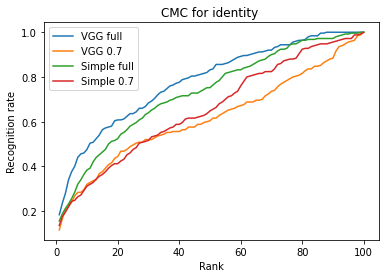

In [ ]:
f = open('vgg_full_identity.pckl', 'rb')
vgg_full = pickle.load(f)
f.close()
f = open('vgg_07_identity.pckl', 'rb')
vgg_07 = pickle.load(f)
f.close()
f = open('simple_full_identity.pckl', 'rb')
simple_full = pickle.load(f)
f.close()
f = open('simple_07_identity.pckl', 'rb')
simple_07 = pickle.load(f)
f.close()


plt.plot(range(1, 100 +1 ), vgg_full)
plt.plot(range(1, 100 +1 ), vgg_07)
plt.plot(range(1, 100 +1 ), simple_full)
plt.plot(range(1, 100 +1 ), simple_07)
plt.title('CMC for identity ')
plt.ylabel('Recognition rate')
plt.xlabel('Rank')
plt.legend(['VGG full', 'VGG 0.7', 'Simple full', 'Simple 0.7'])
plt.savefig(fname = "results/model_rank_identity_2.png", dpi = 300)

**4.4.b** Set to evaluate ethnicity classification models

In [ ]:
vgg_full = calculate_rank("model-18-ethnicity/models/0026-vgg16_1.h5", "ethnicity")
vgg_full_arr = np.char.mod('%f', vgg_full)
vgg_07 = calculate_rank("model-16-ethnicity/models/0003-vgg16_1.h5", "ethnicity")
vgg_07_arr = np.char.mod('%f', vgg_07)
simple_full = calculate_rank("model-simple-ethnicity/models/0030-simple_1.h5", "ethnicity")
simple_full_arr = np.char.mod('%f', simple_full)
simple_07 = calculate_rank("model-simple07-ethnicity/models/0028-simple_1.h5", "ethnicity")
simple_07_arr = np.char.mod('%f', simple_full)

print("VGG Full Ethnicity Rank:    " + " | ".join(vgg_full_arr))
print("VGG 0.7 Ethnicity Rank:     " + " | ".join(vgg_07_arr))
print("Simple Full Ethnicity Rank: " + " | ".join(simple_full_arr))
print("Simple 0.7 Ethnicity Rank: " + " | ".join(simple_07_arr))

Top 1 155
Top 1 153
Top 1 159
Top 1 154
VGG Full Ethnicity Rank:    0.620000 | 0.812000 | 0.912000 | 0.936000 | 0.956000 | 0.988000 | 1.000000
VGG 0.7 Ethnicity Rank:     0.612000 | 0.800000 | 0.916000 | 0.948000 | 0.976000 | 0.988000 | 1.000000
Simple Full Ethnicity Rank: 0.636000 | 0.840000 | 0.912000 | 0.940000 | 0.956000 | 0.984000 | 1.000000
Simple 0.7 Ethnicity Rank: 0.636000 | 0.840000 | 0.912000 | 0.940000 | 0.956000 | 0.984000 | 1.000000


**4.4.c** Set to evaluate gender classification models

In [ ]:
vgg_full = calculate_rank("model-18-gender/models/0001-vgg16_1.h5", "gender")
vgg_full_arr = np.char.mod('%f', vgg_full)
vgg_07 = calculate_rank("model-16-gender/models/0001-vgg16_1.h5", "gender")
vgg_07_arr = np.char.mod('%f', vgg_07)
simple_full = calculate_rank("model-simple-gender/models/0001-simple_1.h5", "gender")
simple_full_arr = np.char.mod('%f', simple_full)
simple_07 = calculate_rank("model-simple07-gender/models/0001-simple_1.h5", "gender")
simple_07_arr = np.char.mod('%f', simple_full)

print("VGG Full Gender Rank:    " + " | ".join(vgg_full_arr))
print("VGG 0.7 Gender Rank:     " + " | ".join(vgg_07_arr))
print("Simple Full Gender Rank: " + " | ".join(simple_full_arr))
print("Simple 0.7 Gender Rank: " + " | ".join(simple_07_arr))

Top 1 229
Top 1 229
Top 1 229
Top 1 229
VGG Full Gender Rank:    0.916000 | 1.000000
VGG 0.7 Gender Rank:     0.916000 | 1.000000
Simple Full Gender Rank: 0.916000 | 1.000000
Simple 0.7 Gender Rank: 0.916000 | 1.000000


# ResNet - WIP - not finished

Resnet example - doesnt work yet

In [ ]:
import numpy
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50


checkpoint = ModelCheckpoint("100-resnet_1.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)


class ConvolutionalResModel():

    def __init__(self, dataSet=None):
        if dataSet is None:
            raise Exception("DataSet is required in this model")
        self.shape = numpy.array([IMG_WIDTH, IMG_HEIGHT, 3])
        if dataSet is not None:
            self.objects = dataSet.objects
            self.labels = dataSet.labels
            #self.obj_validation = dataSet.obj_validation
            #self.labels_validation = dataSet.labels_validation
            self.number_labels = dataSet.number_labels
            self.n_classes = dataSet.n_classes
        self.init_model()
        self.cnn.compile(loss='categorical_crossentropy',
                         optimizer=Common.get_sgd_optimizer(),
                         metrics=['accuracy'])

    def init_model(self):
        base_model = ResNet50(weights= None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        base_model = GlobalAveragePooling2D()(base_model)
        base_model = Dropout(0.7)(base_model)
        predictions = Dense(self.num_classes, activation= 'softmax')(base_model)
        self.cnn = Model(inputs = base_model.input, outputs = predictions)
        self.cnn.summary()

    def train(self, n_epochs=100, batch=32):
        self.cnn.fit(self.objects, self.labels,
                       batch_size=batch,
                       epochs=n_epochs,
                     validation_split=0.05,
                     steps_per_epoch=30,
                     shuffle=True, 
                     callbacks=[checkpoint])

    def get_model(self):
        return self.cnn

    def predict(self, image):
        image = Common.to_float(image)
        result = self.cnn.predict(image)
        print(result)

In [ ]:
cnn = ConvolutionalResModel(dataSet)
cnn.train(n_epochs=100)